# Convergence Criteria Analysis

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

### Method Definition

In [2]:
def get_performance_metrics(ranked_file, full_analysis_file, conv_gen):
    '''
    Calculates performance metrics at* given generation for single run

    *Up to and including given generation

    Champion - best rank achieved in run
    Coverage - number of elite polymers (rank <= 100) found in run
    Speedup - total possible calculations/number of calculations performed in run

    Paramaters
    ----------
    ranked_file: str
        file path to csv ranking entire hexamer pool by single property value
    full_analysis_file: str
        file path to full analysis file for given run
    conv_gen: int
        generation at which to evaluate perfomance metrics
    
    Returns
    -------
    performanc_metrics: list
        [champion, coverage, speedup]
    '''

    ranked_data = pd.read_csv(ranked_file)
    ga_data = pd.read_csv(full_analysis_file)

    # slice out data up to and including convergence generation
    ga_data = ga_data[ga_data['gen'] <= conv_gen]
    # get all unique polymers found up to and including convergence generation
    unique_poly = pd.DataFrame(data = ga_data['filename'].unique(), columns = ['polymer'])

    # make sure new df of unique polymers sorted by rank
    ranked_ga = unique_poly.merge(ranked_data, how='left', on='polymer')
    ranked_ga = ranked_ga.sort_values(by=['rank'], ascending=True, ignore_index=True)

    # CHAMPION - best rank achieved in ga run
    champion = ranked_ga.loc[0, 'rank']

    # COVERAGE - number of elite polymers (rank <= 100) found in ga run
    coverage = len(ranked_ga[ranked_ga['rank'] <= 100])

    # SPEEDUP - total possible calculations/number of calculations run (i.e. # unique polymers found)
    speedup = 100128/len(ranked_ga)

    perform_metrics = [champion, coverage, speedup]
    
    return(perform_metrics)

In [3]:
def make_pm_csv_convergence(min_spear, min_counter):
    '''
    Makes csv of performance metrics (champion, coverage, speedup) for given convergence run series at given convergence criteria
     - Columns: run, conv_gen, champion, coverage, speedup
     - average & std_dev rows given for each metric column

      * csv created in working directory

    Paramaters
    ----------
    series_name: str
        name of run series
    min_spear: float
        minimum spearman correlation coefficient for convergence
    min_counter: int
        # of consecutive generations meeting min_spear for convergence
    
    Returns
    -------
    none
    '''

    master_df = pd.DataFrame()
    # loop over all 15 runs in given series
    for file in glob.glob('1000_gen_quick_files/quick_analysis*.csv'):
        
        # parse labels from series & file name
        run_name = file.split('analysis_')[1].split('.csv')[0]
        property = run_name[:-2]
        
        # read in file as dataframe
        df = pd.read_csv(file)

        # make new conv_counter column
        for idx, row in df.iterrows():
            if row['spearman'] >= min_spear:
                counter += 1
            else:
                counter = 0

            df.loc[idx, 'counter'] = counter

        # find [first] convergence generation
        try:
            conv_gen = df.loc[df.index[df['counter']==min_counter][0], 'gen']
        except:
            conv_gen = 10000

        # get performance metrics at [first] convergence generation
        ranked_file = 'ranked_hexamer_data/ranked_%s.csv' % property
        full_analysis_file = '1000_gen_full_files/full_analysis_%s.csv' % (run_name)
        champion, coverage, speedup = get_performance_metrics(ranked_file, full_analysis_file, conv_gen)

        temp_df = pd.DataFrame({'run':[run_name], 'conv_gen':[conv_gen], 'champion':[champion], 'coverage':[coverage], 'speedup':[speedup]})
        master_df = master_df.append(temp_df)

    # sort columns by run name
    master_df = master_df.sort_values(by='run')
    
    # create csv
    min_spear_format = '0' + str(min_spear).split('.')[1]
    output_name = 'conv_performance_' + min_spear_format + '_' + str(min_counter) + '.csv'

    master_df.to_csv(output_name, index=False)

### Make CSVs: Performance Metrics at all Convergence Criteria

Performance metric CSVs located in all_runs_performance directory.

In [4]:
spear_list = [0.6, 0.7, 0.8, 0.9]
counter_list = [5,10,25,50,100]

In [5]:
# # commented out to prevent accidental overwrite
# for min_spear in spear_list:
#     for min_counter in counter_list:
#         make_pm_csv_convergence(min_spear, min_counter)

### Data Processing

In [6]:
# initialize dataframes
champ_df = pd.DataFrame()
cov_df = pd.DataFrame()
speed_df = pd.DataFrame()

med_df = pd.DataFrame()

for file in glob.glob('all_runs_performance/conv_performance*.csv'):
    # read in file for given run as a DF
    temp_df = pd.read_csv(file)

    # make lexicographically sortable column name for given run
    temp1 = file.split('performance_')[1].split('_')[0]
    temp2 = file.split('performance_')[1].split('_')[1].split('.csv')[0]

    if len(temp2)==1:
        temp2 = '00' + temp2
    elif len(temp2)==2:
        temp2 = '0' + temp2

    conv_crit = temp1 + '_' + temp2

    # add given run data to each PM dataframe
    champ_df[conv_crit] = temp_df['champion']
    cov_df[conv_crit] = temp_df['coverage']
    speed_df[conv_crit] = temp_df['speedup']

    row_med_df = pd.DataFrame({'run':[conv_crit], 'champion':[temp_df['champion'].median()], 'coverage':[temp_df['coverage'].median()], 'speedup':[temp_df['speedup'].median()]})
    med_df = med_df.append(row_med_df, ignore_index=True)

# sort DF by column name
champ_df = champ_df.reindex(sorted(champ_df.columns), axis=1)
med_df = med_df.sort_values(by=['run'], ignore_index=True)

In [7]:
champ_df.head()

,06_005,06_010,06_025,06_050,06_100,07_005,07_010,07_025,07_050,07_100,08_005,08_010,08_025,08_050,08_100,09_005,09_010,09_025,09_050,09_100
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,306.0,74.0,7.0,4.0,1.0,17.0,17.0,4.0,1.0,1.0,17.0,17.0,4.0,1.0,1.0,17.0,17.0,1.0,1.0,1.0
2,160.0,10.0,1.0,1.0,1.0,141.0,10.0,1.0,1.0,1.0,141.0,10.0,1.0,1.0,1.0,10.0,10.0,1.0,1.0,1.0
3,306.0,41.0,41.0,41.0,9.0,306.0,41.0,21.0,21.0,1.0,306.0,41.0,21.0,21.0,1.0,306.0,41.0,21.0,21.0,1.0
4,4.0,4.0,4.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0


In [8]:
med_df.head()

,run,champion,coverage,speedup
0,06_005,4.0,4.0,277.362881
1,06_010,3.0,8.0,139.843575
2,06_025,2.0,15.0,92.283871
3,06_050,1.0,37.0,50.749113
4,06_100,1.0,55.0,27.976530


### Performance Metric Plots

In [9]:
# set standard plot formatting
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 300

colors = ['C0', 'C1', 'C2', 'C3']

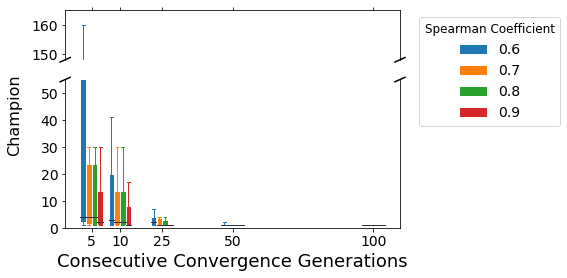

In [10]:
df = champ_df
label = 'Champion'

# helpful stackoverflow thread: https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
# there are 4 individuals, each one tested under 3 different settings

# --- Combining data:
spear_6 = [df.loc[0:14, '06_005'].to_numpy(), df.loc[0:14, '06_010'].to_numpy(), df.loc[0:14, '06_025'].to_numpy(), df.loc[0:14, '06_050'].to_numpy(), df.loc[0:14, '06_100'].to_numpy()]
spear_7 = [df.loc[0:14, '07_005'].to_numpy(), df.loc[0:14, '07_010'].to_numpy(), df.loc[0:14, '07_025'].to_numpy(), df.loc[0:14, '07_050'].to_numpy(), df.loc[0:14, '07_100'].to_numpy()]
spear_8 = [df.loc[0:14, '08_005'].to_numpy(), df.loc[0:14, '08_010'].to_numpy(), df.loc[0:14, '08_025'].to_numpy(), df.loc[0:14, '08_050'].to_numpy(), df.loc[0:14, '08_100'].to_numpy()]
spear_9 = [df.loc[0:14, '09_005'].to_numpy(), df.loc[0:14, '09_010'].to_numpy(), df.loc[0:14, '09_025'].to_numpy(), df.loc[0:14, '09_050'].to_numpy(), df.loc[0:14, '09_100'].to_numpy()]

# we compare the performances of the 4 individuals within the same set of 3 settings 
data_groups = [spear_6, spear_7, spear_8, spear_9]

# --- Labels for data:
labels_list = ['5','10', '25', '50', '100']
# width       = 1/len(labels_list)
width = 2
# xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(spear_6)) ]
xlocations = [5, 15, 30, 55, 105]
symbol      = ''
# ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
ymin        = 0
ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])



# To break the y-axis:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]})

# zoom-in / limit the view to different portions of the data
ax.set_ylim(148, 165)  # outliers only
ax.set_yticks([150, 160])
ax2.set_ylim(0, 55)  # most of the data
ax2.set_yticks([0, 10, 20, 30, 40, 50])

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add diagonal lines at axis break
d = .015  # how big to make the diagonal lines in axes coordinates

# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-3*d, +3*d), **kwargs)        # top-left diagonal
ax.plot((1-d, 1+d), (-3*d,+3*d), **kwargs)


kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xlabel('Consecutive Convergence Generations')
# plt.ylabel(label)
plt.title('')

space = len(data_groups)/2
offset = len(data_groups)/2


# --- Offset the positions per group:

group_positions = []
for num, dg in enumerate(data_groups):    
    _off = (0 - space + (0.5+num))
    group_positions.append([x+_off*(width+0.01) for x in xlocations])

# make list of boxes object for legend
boxes_list = []
for dg, pos, c in zip(data_groups, group_positions, colors):
    boxes = ax.boxplot(dg, 
                sym=symbol,
                labels=['']*len(labels_list),
                positions=pos, 
                widths=width, 
                boxprops=dict(color='white', facecolor=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                medianprops=dict(color='#2B303A'),
                patch_artist=True,
                )
    boxes_list.append(boxes)

for dg, pos, c in zip(data_groups, group_positions, colors):
    boxes = ax2.boxplot(dg, 
                sym=symbol,
                labels=['']*len(labels_list),
                positions=pos, 
                widths=width, 
                boxprops=dict(color='white', facecolor=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                medianprops=dict(color='#2B303A'),
                patch_artist=True,
                )
boxes_list.append(boxes)

ax.set_xticks( xlocations )
ax.set_xticklabels( labels_list, rotation=0 )

ax2.set_xticks( xlocations )
ax2.set_xticklabels( labels_list, rotation=0 )

plt.text(-25, 28, label, rotation='vertical', size=16)

# helpful on understanding boxplot objects for legend: https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
ax.legend([boxes_list[0]["boxes"][0], boxes_list[1]["boxes"][0], boxes_list[2]["boxes"][0], boxes_list[3]["boxes"][0]], ['0.6', '0.7', '0.8', '0.9'], loc='upper right', title='Spearman Coefficient', title_fontproperties={'size':'12'}, bbox_to_anchor=(1.5, 1))

# commented out to prevent accidental overwrite
# plt.savefig('conv_champion.png', transparent=False, bbox_inches='tight')

plt.show()

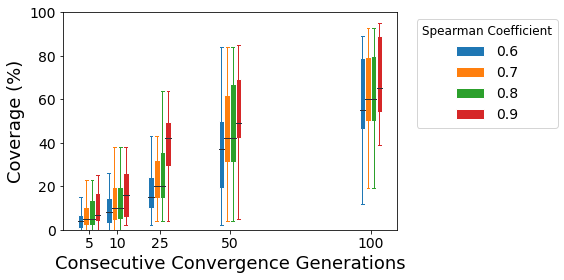

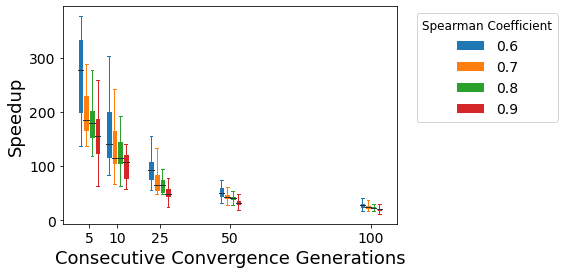

In [11]:
def make_group_boxplot(df, label, ylimits):

    # helpful stackoverflow thread: https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
    # there are 4 individuals, each one tested under 3 different settings

    # --- Combining your data:
    spear_6 = [df.loc[0:14, '06_005'].to_numpy(), df.loc[0:14, '06_010'].to_numpy(), df.loc[0:14, '06_025'].to_numpy(), df.loc[0:14, '06_050'].to_numpy(), df.loc[0:14, '06_100'].to_numpy()]
    spear_7 = [df.loc[0:14, '07_005'].to_numpy(), df.loc[0:14, '07_010'].to_numpy(), df.loc[0:14, '07_025'].to_numpy(), df.loc[0:14, '07_050'].to_numpy(), df.loc[0:14, '07_100'].to_numpy()]
    spear_8 = [df.loc[0:14, '08_005'].to_numpy(), df.loc[0:14, '08_010'].to_numpy(), df.loc[0:14, '08_025'].to_numpy(), df.loc[0:14, '08_050'].to_numpy(), df.loc[0:14, '08_100'].to_numpy()]
    spear_9 = [df.loc[0:14, '09_005'].to_numpy(), df.loc[0:14, '09_010'].to_numpy(), df.loc[0:14, '09_025'].to_numpy(), df.loc[0:14, '09_050'].to_numpy(), df.loc[0:14, '09_100'].to_numpy()]


    # we compare the performances of the 4 individuals within the same set of 3 settings 
    data_groups = [spear_6, spear_7, spear_8, spear_9]

    # --- Labels for your data:
    labels_list = ['5','10', '25', '50', '100']
    # width       = 1/len(labels_list)
    width = 2
    # xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(spear_6)) ]
    xlocations = [5, 15, 30, 55, 105]
    symbol      = ''
    # ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymin        = 0
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])

    ax = plt.gca()
    # ax.set_ylim(ymin,ymax)

    # ax.grid(True, linestyle='dotted')
    # ax.set_axisbelow(True)

    if ylimits:
        plt.ylim(ylimits)
    plt.xlabel('Consecutive Convergence Generations')
    plt.ylabel(label)
    plt.title('')

    space = len(data_groups)/2
    offset = len(data_groups)/2


    # --- Offset the positions per group:

    group_positions = []
    for num, dg in enumerate(data_groups):    
        _off = (0 - space + (0.5+num))
        group_positions.append([x+_off*(width+0.01) for x in xlocations])

    # make list of boxes object for legend
    boxes_list = []
    for dg, pos, c in zip(data_groups, group_positions, colors):
        boxes = ax.boxplot(dg, 
                    sym=symbol,
                    labels=['']*len(labels_list),
                    # labels=labels_list,
                    positions=pos, 
                    widths=width, 
                    boxprops=dict(color='white', facecolor=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
        #            flierprops=dict(color=c, markeredgecolor=c),                       
                    medianprops=dict(color='#2B303A'),
        #           notch=False,  
        #           vert=True, 
        #           whis=1.5,
        #           bootstrap=None, 
        #           usermedians=None, 
        #           conf_intervals=None,
                    patch_artist=True,
                    )
        boxes_list.append(boxes)

    ax.set_xticks( xlocations )
    ax.set_xticklabels( labels_list, rotation=0 )

    # helpful on understanding boxplot objects for legend: https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    ax.legend([boxes_list[0]["boxes"][0], boxes_list[1]["boxes"][0], boxes_list[2]["boxes"][0], boxes_list[3]["boxes"][0]], ['0.6', '0.7', '0.8', '0.9'], loc='upper right', title='Spearman Coefficient', title_fontproperties={'size':'12'}, bbox_to_anchor=(1.5, 1))

    # commented out to prevent accidental overwrite
    # plt.savefig('conv_%s.png' % (label), transparent=False, bbox_inches='tight')

    plt.show()

make_group_boxplot(cov_df, 'Coverage (%)', [0,100])

make_group_boxplot(speed_df, 'Speedup', False)

### Plot Speedup vs Coverage

In [12]:
# helpful https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

def power_law(x, a, b):
    return a*np.power(x, b)

In [13]:
# helpful https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit

x1 = med_df['coverage'].to_numpy()
y1 = med_df['speedup'].to_numpy()

popt, pcov = curve_fit(power_law, x1, y1)

# calculate residuals and r_squared
res = y1 - power_law(x1, *popt)

ss_res = np.sum(res**2)
ss_tot = np.sum((y1-np.mean(y1))**2)
r_squared = 1 - (ss_res / ss_tot)

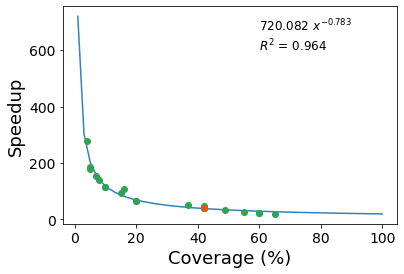

In [14]:
# highlight chosen point
hl = med_df[med_df['run']=='08_050']
x2 = hl['coverage'].to_numpy()
y2 = hl['speedup'].to_numpy()

# label axes
plt.xlabel('Coverage (%)')
plt.ylabel('Speedup')


plt.scatter(x1,y1, c='#31a354', zorder=2)
plt.scatter(x2, y2, c='#e6550d', zorder=3)

x_full = np.linspace(start=1, stop=100, num=50)
plt.plot(x_full, power_law(x_full, *popt), c='#3182bd', zorder=1)

plt.text(60, 600, '%.3f $x^{%.3f}$\n$R^2$ = %.3f' % (popt[0], popt[1], r_squared), size=12)
# plt.title('Median Speedup vs. Coverage', size=12)

# plt.savefig('conv_plot_b.png', transparent=False, bbox_inches='tight')


plt.show()

### Extrapolate Speedup at 100% Coverage

In [15]:
power_law(100, *popt)

19.584710996143475